In [4]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
 
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [5]:
# 1) Load training set
imagePath = "./all/train"
imagePaths = list(paths.list_images(imagePath))
 
data = []
labels = []
 
# 2) Resize
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)
 
# 3) Normalization  
data = np.array(data) / 255.0
labels = np.array(labels)
 
# 4) One-hot encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
labels = to_categorical(integer_encoded)
 
 
# 5) Dividing training sets
(x_train, x_val, y_train, y_val) = train_test_split(data, labels, test_size=0.20, stratify=labels)
 
# 6) Image shape/label check
print(x_train.shape, x_val.shape)
print(label_encoder.classes_)

(160, 224, 224, 3) (40, 224, 224, 3)
['covid' 'normal' 'pneumonia_bac']


In [6]:
model = Sequential()
adam_s = Adam(learning_rate = 0.00001)
 
# 1) Load ResNet50 or VGG16
#model.add(VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='average'))
model.add(ResNet50V2(input_shape=(224, 224, 3),include_top=False, weights='imagenet',pooling='average'))
 
for layer in model.layers:
    layer.trainable = False
 
# 2) Add classifier   
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
 
# 3) Compile and visualize our model
model.compile(loss='categorical_crossentropy', optimizer=adam_s, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 49,296,643
Trainable params: 25,727,747
Non-trainable params: 23,568,896
___________________________________

In [7]:
H = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), batch_size=8)
#H = model.fit(data, labels, epochs=50, validation_split=0.2, batch_size=8)

Epoch 1/50
20/20 [==============================] - 19s 954ms/step - loss: 0.7527 - accuracy: 0.6687 - val_loss: 0.5839 - val_accuracy: 0.7500
Epoch 2/50
20/20 [==============================] - 17s 862ms/step - loss: 0.0809 - accuracy: 1.0000 - val_loss: 0.3140 - val_accuracy: 0.8500
Epoch 3/50
20/20 [==============================] - 17s 867ms/step - loss: 0.0230 - accuracy: 1.0000 - val_loss: 0.2447 - val_accuracy: 0.9250
Epoch 4/50
20/20 [==============================] - 18s 900ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.2009 - val_accuracy: 0.9500
Epoch 5/50
20/20 [==============================] - 19s 925ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.1846 - val_accuracy: 0.9500
Epoch 6/50
20/20 [==============================] - 20s 981ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.1754 - val_accuracy: 0.9250
Epoch 7/50
20/20 [==============================] - 18s 892ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1638 - val_accuracy: 0.9500

[[11  1  0]
 [ 0 14  0]
 [ 0  1 13]]
 
accuracy: 0.9500
sensitivity: 0.9167
specificity: 1.0000


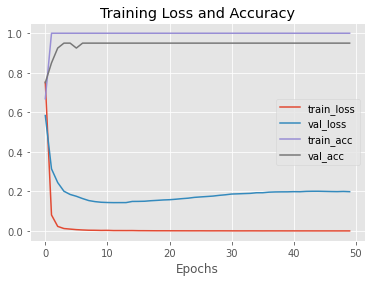

In [8]:
# 1) Analysis
P = model.predict(x_val, batch_size=8)
P = np.argmax(P, axis=1)
# print(classification_report(y_val.argmax(axis=1), P, target_names=label_encoder.classes_))
 
# 2) Visualization
epochs = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="right")
plt.savefig("./s-class-plot-2.png")
 
# 3) Confusion matrix
cm = confusion_matrix(y_val.argmax(axis=1), P)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
specificity = (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]) / (cm[1, 0] + cm[1, 1] + cm[1, 2] + cm[2, 0] + cm[2, 1] + cm[2, 2])
 
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print(" ")
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [9]:
# 1) Load test data
imagePathTest = "./all/test"
imagePathsTest = list(paths.list_images(imagePathTest))
 
dataTest = []
labelsTest = []
 
# 2) Resize
for imagePathTest in imagePathsTest:
    labelTest = imagePathTest.split(os.path.sep)[-2]
    imageTest = cv2.imread(imagePathTest)
    imageTest = cv2.cvtColor(imageTest, cv2.COLOR_BGR2RGB)
    imageTest = cv2.resize(imageTest, (224, 224))
    dataTest.append(imageTest)
    labelsTest.append(labelTest)
 
# 3) Normalization
dataTest = np.array(dataTest) / 255.0
labelsTest = np.array(labelsTest)
 
# 4) One-hot encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labelsTest)
labelsTest = to_categorical(integer_encoded)
 
# 5) Prediction
x_test = dataTest
y_test = labelsTest
T = model.predict(x_test, batch_size=8)
T = np.argmax(T, axis=1)
# print(classification_report(y_test.argmax(axis=1), T, target_names=label_encoder.classes_))
 
# 6) Confusion matrix
cmTest = confusion_matrix(y_test.argmax(axis=1), T)
totalTest = sum(sum(cmTest))
accTest = (cmTest[0, 0] + cmTest[1, 1] + cmTest[2, 2]) / totalTest
sensitivityTest = cmTest[0, 0] / (cmTest[0, 0] + cmTest[0, 1] + cmTest[0, 2])
specificityTest = (cmTest[1, 1] + cmTest[1, 2] + cmTest[2, 1] + cmTest[2, 2]) / (cmTest[1, 0] + cmTest[1, 1] + cmTest[1, 2] + cmTest[2, 0] + cmTest[2, 1] + cmTest[2, 2])
 
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cmTest)
print(" ")
print("accuracy: {:.4f}".format(accTest))
print("sensitivity: {:.4f}".format(sensitivityTest))
print("specificity: {:.4f}".format(specificityTest))

[[9 0 0]
 [0 6 3]
 [0 0 9]]
 
accuracy: 0.8889
sensitivity: 1.0000
specificity: 1.0000


In [15]:
tensorflow.keras.models.save_model(model, "covid/1")

INFO:tensorflow:Assets written to: covid/version/1\assets


In [10]:
#tensorflow.keras.models.save_model(model, "covid-19")

In [11]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
SAVED_MODEL_PATH = './saved_model'
make_directory(SAVED_MODEL_PATH)
MODEL_DIR = SAVED_MODEL_PATH

version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

NameError: name 'make_directory' is not defined

In [ ]:
tf.keras.models.save_model(
  model,
  export_path,
  overwrite=True,
  include_optimizer=True,
  save_format=None,
  signatures=None,
  options=None
)
print('\nSaved model:')